In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas scikit-learn seaborn matplotlib


🔎 Veri kümesi boyutu: (4937, 2)
label
0    2638
1    2299
Name: count, dtype: int64

📊 Accuracy: 0.9949392712550608

📊 Classification Report:
               precision    recall  f1-score   support

           0     0.9962    0.9943    0.9953       528
           1     0.9935    0.9957    0.9946       460

    accuracy                         0.9949       988
   macro avg     0.9948    0.9950    0.9949       988
weighted avg     0.9949    0.9949    0.9949       988



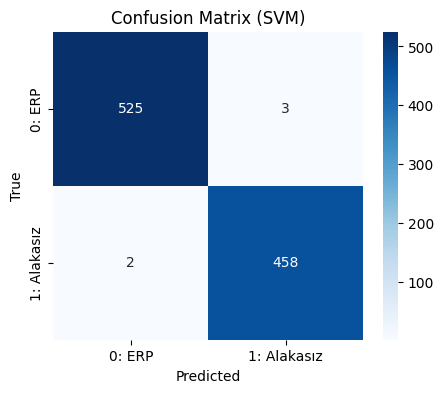

👉 'ERP nedir?' --> Tahmin: 0
👉 'Hava durumu nasıl?' --> Tahmin: 1
👉 'Mizan raporu nasıl hazırlanır?' --> Tahmin: 0
👉 'Merhaba nasılsın?' --> Tahmin: 1

✅ Model ve vectorizer kaydedildi: /content/drive/MyDrive/new-fine_tuned_erp_svm


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

# ----------------------
# 1. Veri Yükleme
# ----------------------
df = pd.read_json("/content/classifications_data (1).json")

print("🔎 Veri kümesi boyutu:", df.shape)
print(df['label'].value_counts())

# ----------------------
# 2. Stratified Train/Test Split
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# ----------------------
# 3. TF-IDF Vectorizer
# ----------------------
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),   # unigram + bigram
    max_features=5000,   # en sık geçen 5000 özelliği al
    stop_words=None
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# ----------------------
# 4. SVM Classifier
# ----------------------
svm_clf = LinearSVC(class_weight="balanced", random_state=42)
svm_clf.fit(X_train_tfidf, y_train)

# ----------------------
# 5. Tahmin ve Skorlar
# ----------------------
y_pred = svm_clf.predict(X_test_tfidf)

print("\n📊 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# ----------------------
# 6. Confusion Matrix
# ----------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["0: ERP", "1: Alakasız"],
            yticklabels=["0: ERP", "1: Alakasız"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (SVM)")
plt.show()

# ----------------------
# 7. Örnek Tahmin
# ----------------------
test_sentences = [
    "ERP nedir?",
    "Hava durumu nasıl?",
    "Mizan raporu nasıl hazırlanır?",
    "Merhaba nasılsın?"
]

test_vec = vectorizer.transform(test_sentences)
preds = svm_clf.predict(test_vec)
for s, p in zip(test_sentences, preds):
    print(f"👉 '{s}' --> Tahmin: {p}")

# ----------------------
# 8. Model Kaydetme
# ----------------------
save_path = "/content/drive/MyDrive/new-fine_tuned_erp_svm"
os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, "svm_model.pkl"), "wb") as f:
    pickle.dump(svm_clf, f)

with open(os.path.join(save_path, "tfidf_vectorizer.pkl"), "wb") as f:
    pickle.dump(vectorizer, f)

print(f"\n✅ Model ve vectorizer kaydedildi: {save_path}")


In [ ]:
import pandas as pd
import pickle
import os

# ----------------------
# 1. Model ve Vectorizer Yükleme
# ----------------------
save_path = "/content/drive/MyDrive/new-fine_tuned_erp_svm"

with open(os.path.join(save_path, "svm_model.pkl"), "rb") as f:
    svm_clf = pickle.load(f)

with open(os.path.join(save_path, "tfidf_vectorizer.pkl"), "rb") as f:
    vectorizer = pickle.load(f)

# ----------------------
# 2. Dataset Yükleme
# ----------------------
df = pd.read_json("/content/classifications_data (1).json")

# ----------------------
# 3. Tahminleri Hesapla
# ----------------------
X_vec = vectorizer.transform(df["text"])
df["predicted"] = svm_clf.predict(X_vec)

# ----------------------
# 4. Karşılaştırma
# ----------------------
# İlk 20 örneği kontrol için yazdıralım
print(df.head(20)[["text", "label", "predicted"]])

# ----------------------
# 5. Hatalı Tahminleri Göster
# ----------------------
errors = df[df["label"] != df["predicted"]]
print(f"\n❌ Hatalı sınıflandırma sayısı: {len(errors)}")
print(errors.head(20)[["text", "label", "predicted"]])  # ilk 20 hatayı yazdır


                                                 text  label  predicted
0   Mizan nedir ve neden hazırlanır? İşletmem döne...      0          0
1   Mizan nasıl hazırlanır? Yevmiye defterinden mi...      0          0
2   Mizan hangi türlerde düzenlenir? Şirketim ay s...      0          0
3   Mizanda hata nasıl anlaşılır? Mizan tablosunu ...      0          0
4   ERP’de mizan raporu nasıl alınır? ERP sistemin...      0          0
5   Mizan bilanço hazırlığında nasıl rol oynar? Bi...      0          0
6   Denetimde mizan nasıl kullanılır? Bağımsız den...      0          0
7   Mizan düzenlenmezse ne olur? Mizan tutmazsak h...      0          0
8   Mizan yöneticilere nasıl fayda sağlar? Şirket ...      0          0
9   Mizan ile envanter ilişkisi nedir? Envanter iş...      0          0
10  Bakiye nedir ve nasıl tanımlanır? ERP raporlar...      0          0
11  Cari hesaplarda bakiye nasıl kullanılır? Müşte...      0          0
12  Kasa hesabında bakiye nasıl izlenir? Kasa hesa...      0    

In [ ]:
# ----------------------
# 6. Ekstra 5 Soruluk Test
# ----------------------
extra_questions_20 = [
    # ERP soruları (0 beklenir)
    "cari nedir nasıl alınır",
    "çek makbuzu üzerinde hangi bilgiler yer alır? Makbuzda hangi alanlar zorunludur?",
    "Mizan kaydını indirebilirmiyim? ",
    "Tahsilat fişi nedir nasıl alabilirim",
    "Tediye nedir nasıl alınır?",
    "ERP sisteminde yeni müşteri kartı nasıl tanımlanır?",
    "Bakiye raporları yönetime hangi karar desteğini sağlar?",
    "Muhasebe fişlerinde yapılan hatalar ERP’de nasıl düzeltilir?",
    "ERP üzerinden toplu ödeme talimatı nasıl verilir?",
    "Stok sayımı sonrası ERP’de hangi rapor güncellenir?",
    "Gelir tablosu ile nakit akış tablosu arasında nasıl bir fark vardır?",
    "ERP’de dekont numarası takibi hangi modülde yapılır?",
    "Cari hesap mutabakat mektubu ERP’den nasıl hazırlanır?",
    "ERP’de personel maaş ödemeleri hangi modülden takip edilir?",
    "Kur farkı kayıtları ERP sistemine nasıl işlenir?",
    "Mizan nasıl ",

    # Alakasız sorular (1 beklenir)
    "nasıl giriş yaparım ?",
    "Yaz tatili için en çok tercih edilen şehirler hangileri?",
    "Dün gece izlediğin film nasıldı?",
    "Hangi futbolcu bu yıl transfer rekoru kırdı?",
    "Kahvaltıda en sevilen yiyecekler nelerdir?",
    "Tatilde deniz mi dağ mı tercih edersin?",
    "Son zamanlarda en popüler mobil oyun hangisi?",
    "Bugün dolar kuru ne kadar oldu?",
    "İstanbul’da trafik yoğunluğu şu an nasıl?",
    "En sevilen tatlı hangisidir?"
]

extra_vec = vectorizer.transform(extra_questions_20)
extra_preds = svm_clf.predict(extra_vec)

for q, p in zip(extra_questions_20, extra_preds):
    print(f"👉 '{q}' --> Tahmin: {p}")


👉 'cari nedir nasıl alınır' --> Tahmin: 1
👉 'çek makbuzu üzerinde hangi bilgiler yer alır? Makbuzda hangi alanlar zorunludur?' --> Tahmin: 0
👉 'Mizan kaydını indirebilirmiyim? ' --> Tahmin: 0
👉 'Tahsilat fişi nedir nasıl alabilirim' --> Tahmin: 0
👉 'Tediye nedir nasıl alınır?' --> Tahmin: 1
👉 'ERP sisteminde yeni müşteri kartı nasıl tanımlanır?' --> Tahmin: 0
👉 'Bakiye raporları yönetime hangi karar desteğini sağlar?' --> Tahmin: 0
👉 'Muhasebe fişlerinde yapılan hatalar ERP’de nasıl düzeltilir?' --> Tahmin: 0
👉 'ERP üzerinden toplu ödeme talimatı nasıl verilir?' --> Tahmin: 0
👉 'Stok sayımı sonrası ERP’de hangi rapor güncellenir?' --> Tahmin: 0
👉 'Gelir tablosu ile nakit akış tablosu arasında nasıl bir fark vardır?' --> Tahmin: 0
👉 'ERP’de dekont numarası takibi hangi modülde yapılır?' --> Tahmin: 0
👉 'Cari hesap mutabakat mektubu ERP’den nasıl hazırlanır?' --> Tahmin: 0
👉 'ERP’de personel maaş ödemeleri hangi modülden takip edilir?' --> Tahmin: 0
👉 'Kur farkı kayıtları ERP sistemine n